# Testing Ball Counter Dataset

This notebook tests the dataset loading and preprocessing functionality for the ball counting project.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torch.utils.data import DataLoader
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Import Dataset Module

First, let's import our dataset module. Make sure this notebook is in the same directory as `dataset.py`.

In [2]:
# Import dataset module
import src.dataset
from src.dataset import BallDataset, load_dataset, get_data_loaders

print("Dataset module imported successfully!")

Dataset module imported successfully!


## 2. Specify Data Directory

Enter the path to your data directory. This should be the directory that contains subdirectories named 1, 2, 3, 4, 5.

In [3]:
# Set your data directory here
data_dir = "/home/embody_data/raw"  # Update this to your data directory path

# Check if directory exists
if not os.path.exists(data_dir):
    print(f"Error: Directory '{data_dir}' not found!")
else:
    print(f"Found data directory: {data_dir}")

# Check class directories
class_dirs = []
for i in range(1, 6):
    class_path = os.path.join(data_dir, str(i))
    if os.path.exists(class_path):
        num_images = 0
        for root, dirs, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    num_images += 1
        class_dirs.append((str(i), num_images))

if class_dirs:
    print("\nFound class directories:")
    for class_name, num_images in class_dirs:
        print(f"  Class {class_name}: {num_images} images")
else:
    print("\nNo class directories (1-5) found in data directory!")

Found data directory: /home/embody_data/raw

Found class directories:
  Class 1: 87654 images
  Class 2: 162368 images
  Class 3: 236666 images
  Class 4: 311013 images
  Class 5: 385361 images


## 3. Load Sample Images

Let's load a small set of images from each class to test our dataset.

In [4]:
# Load a small dataset (5 images per class)
try:
    image_paths, labels = load_dataset(data_dir, num_samples_per_class=5)
    print(f"Successfully loaded {len(image_paths)} images")
    
    # Count images per class
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"  Class {label+1}: {count} images")
    
    # Check image paths to make sure they exist
    all_exist = all(os.path.exists(path) for path in image_paths)
    print(f"All image paths exist: {all_exist}")
    
    # Print first few paths
    print("\nFirst few image paths:")
    for i, path in enumerate(image_paths[:3]):
        print(f"  {i+1}. {path} (Class {labels[i]+1})")
        
except Exception as e:
    print(f"Error loading dataset: {e}")

Successfully loaded 25 images
  Class 1: 5 images
  Class 2: 5 images
  Class 3: 5 images
  Class 4: 5 images
  Class 5: 5 images
All image paths exist: True

First few image paths:
  1. /home/embody_data/raw/1/1742360647.53571/images/frame_000042.png (Class 1)
  2. /home/embody_data/raw/1/1742361158.3544118/images/frame_000094.png (Class 1)
  3. /home/embody_data/raw/1/1742361578.1779065/images/frame_000053.png (Class 1)


## 4. Visualize Original Images

Let's look at some of the original images to make sure they're loaded correctly.

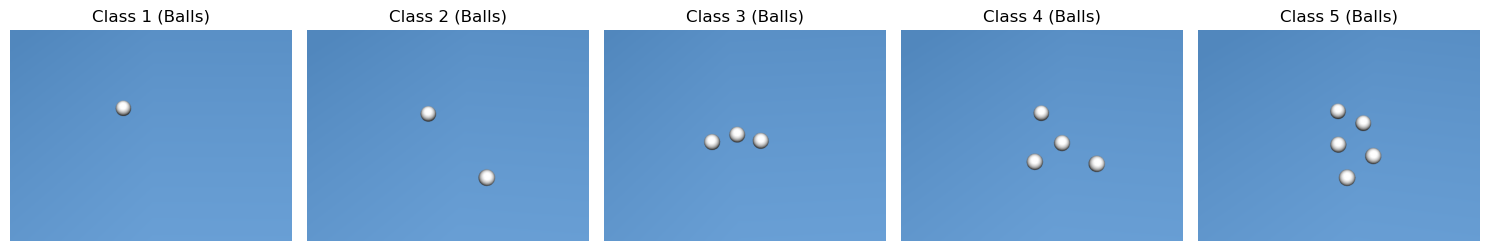

In [5]:
# Display some original images
if 'image_paths' in locals() and len(image_paths) > 0:
    plt.figure(figsize=(15, 10))
    
    # Select one image from each class if available
    selected_indices = []
    for label in range(5):  # 0-4 (representing 1-5 balls)
        indices = [i for i, l in enumerate(labels) if l == label]
        if indices:
            selected_indices.append(indices[0])
    
    # If we don't have all classes, just take the first few images
    if len(selected_indices) < 5:
        selected_indices = list(range(min(5, len(image_paths))))
    
    for i, idx in enumerate(selected_indices):
        try:
            img_path = image_paths[idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, len(selected_indices), i+1)
            plt.imshow(img)
            plt.title(f"Class {labels[idx]+1} (Balls)")
            plt.axis('off')
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()
else:
    print("No images available to display")

## 5. Test Dataset Class

Now let's create a dataset and test the preprocessing functionality (resizing and binarization).

Created dataset with 25 samples


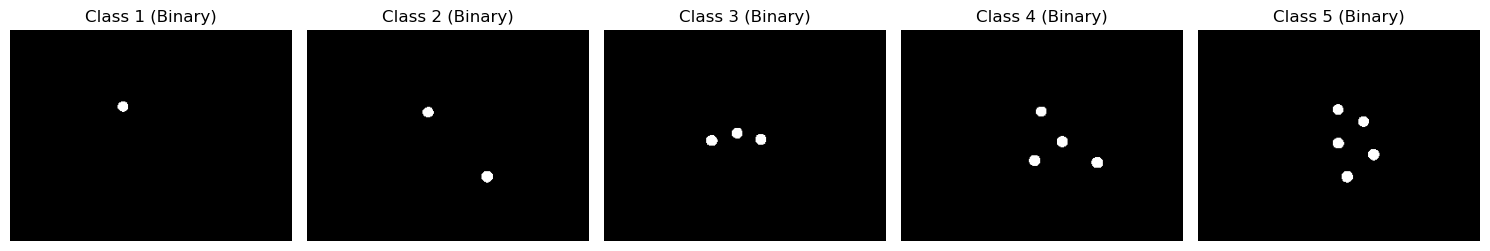

Image tensor shape: torch.Size([1, 240, 320])
Processed image statistics:
  Min: 0.0000, Max: 1.0000, Mean: 0.0082


In [6]:
# Create dataset with binary preprocessing
if 'image_paths' in locals() and len(image_paths) > 0:
    # Create dataset
    dataset = BallDataset(image_paths, labels, binary=True)
    print(f"Created dataset with {len(dataset)} samples")
    
    # Get and display some processed images
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(selected_indices):
        # Get processed image from dataset
        img_tensor, label = dataset[idx]
        
        # Convert tensor to numpy for display
        img_np = img_tensor.squeeze().numpy()
        
        # Display
        plt.subplot(1, len(selected_indices), i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Class {label+1} (Binary)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Image tensor shape:", img_tensor.shape)
    print("Processed image statistics:")
    print(f"  Min: {img_np.min():.4f}, Max: {img_np.max():.4f}, Mean: {img_np.mean():.4f}")
else:
    print("No images available to create dataset")

## 6. Compare Original vs. Processed Images

Now let's compare original and processed (binary) versions side by side.

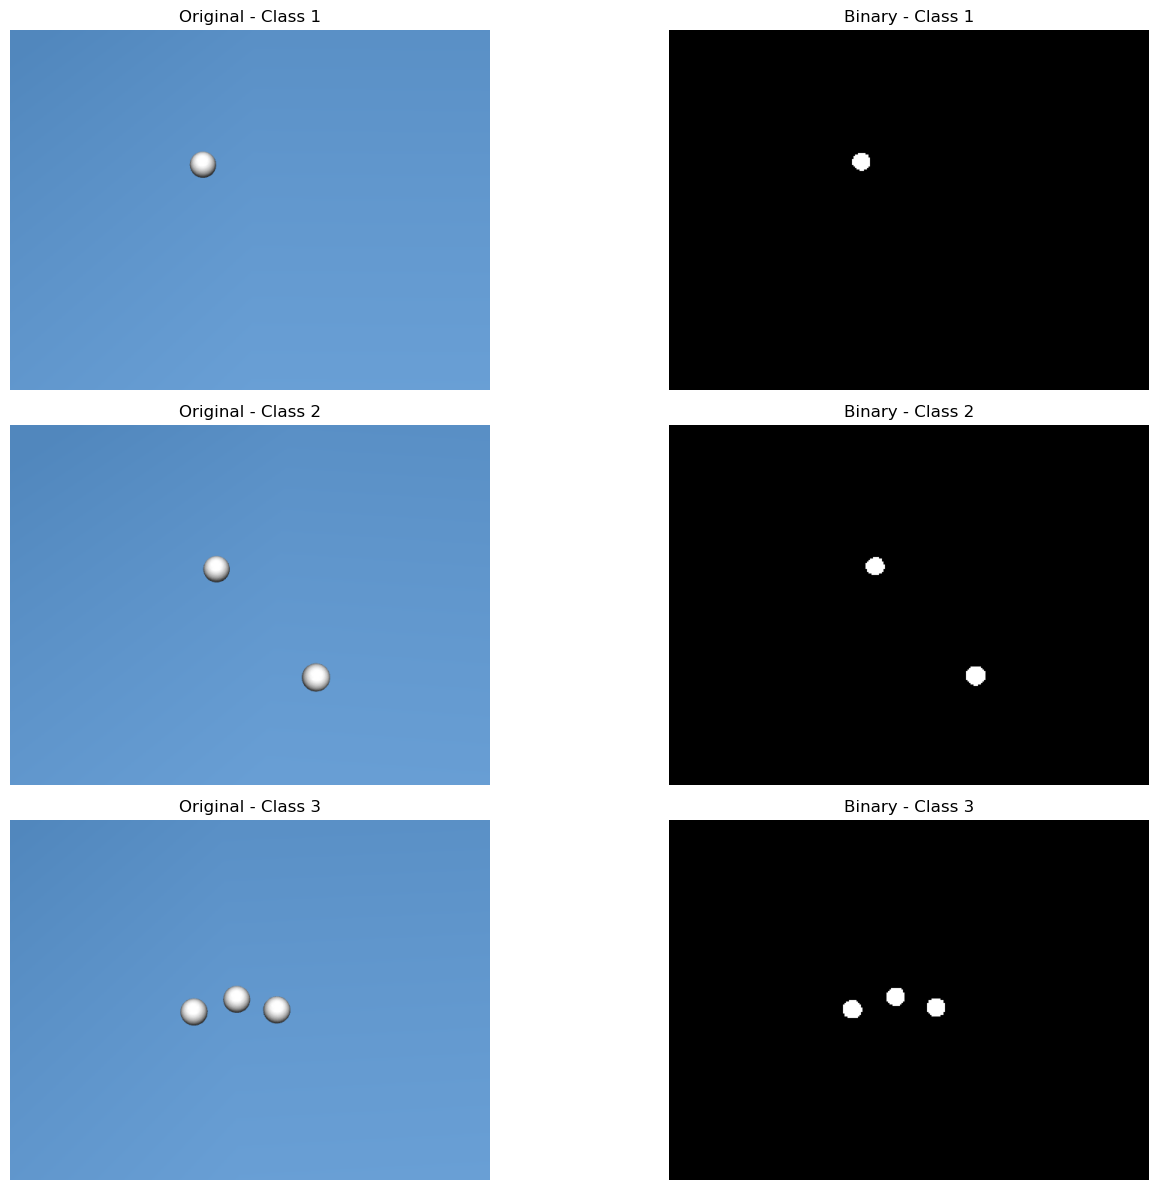

In [7]:
# Compare original and binary versions
if 'dataset' in locals() and len(dataset) > 0:
    plt.figure(figsize=(15, 12))
    
    for i, idx in enumerate(selected_indices[:3]):  # Show just 3 examples
        # Original image
        img_path = image_paths[idx]
        orig_img = cv2.imread(img_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        # Processed image
        proc_img, _ = dataset[idx]
        proc_img = proc_img.squeeze().numpy()
        
        # Display original
        plt.subplot(3, 2, i*2+1)
        plt.imshow(orig_img)
        plt.title(f"Original - Class {labels[idx]+1}")
        plt.axis('off')
        
        # Display binary
        plt.subplot(3, 2, i*2+2)
        plt.imshow(proc_img, cmap='gray')
        plt.title(f"Binary - Class {labels[idx]+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No dataset available for comparison")

## 7. Test DataLoader Functionality

Finally, let's test creating data loaders and getting batches of images.

Train: 69, Validation: 16, Test: 15 images
Created data loaders:
  Train: 18 batches
  Validation: 4 batches
  Test: 4 batches

Batch shape: torch.Size([4, 1, 240, 320]), Labels: tensor([2, 4, 1, 3])


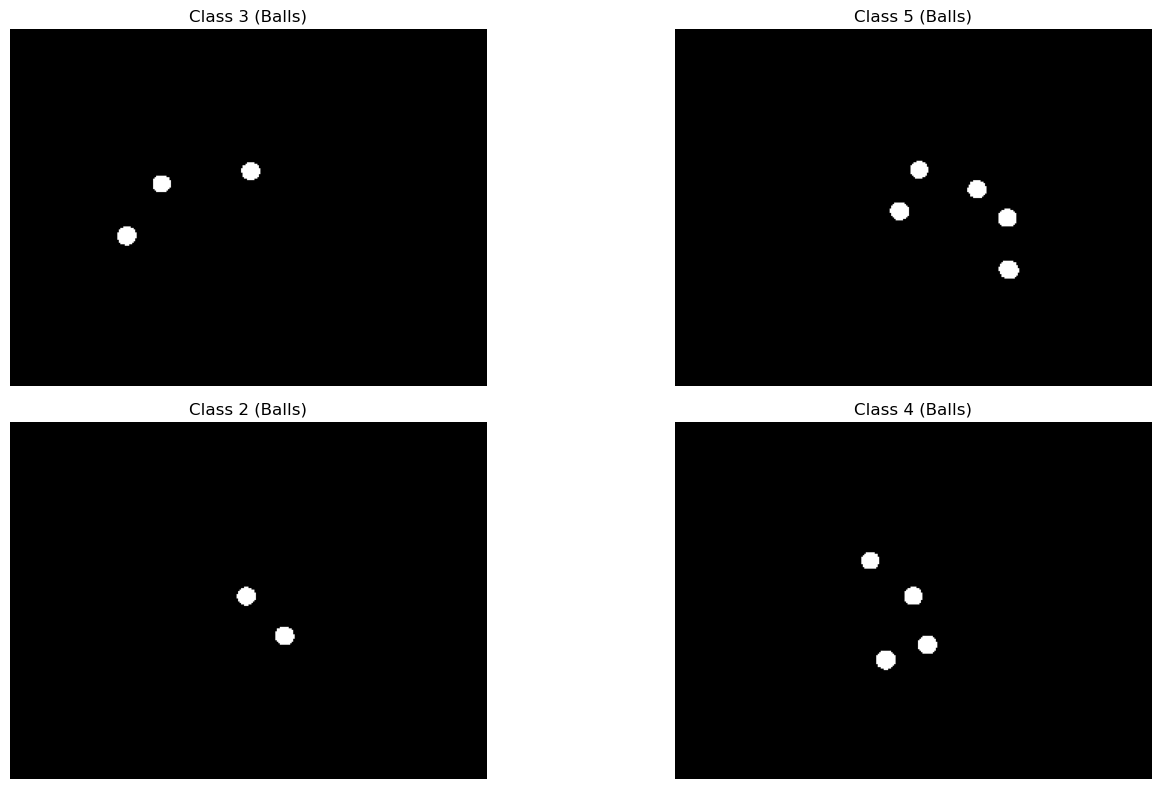

In [10]:
# Create data loaders
try:
    train_loader, val_loader, test_loader = get_data_loaders(
        data_dir, num_samples_per_class=20, batch_size=4
    )
    
    print(f"Created data loaders:")
    print(f"  Train: {len(train_loader)} batches")
    print(f"  Validation: {len(val_loader)} batches")
    print(f"  Test: {len(test_loader)} batches")
    
    # Get a batch from training loader
    try:
        batch_x, batch_y = next(iter(train_loader))
        print(f"\nBatch shape: {batch_x.shape}, Labels: {batch_y}")
        
        # Display the batch
        plt.figure(figsize=(15, 8))
        for i in range(min(4, batch_x.shape[0])):
            plt.subplot(2, 2, i+1)
            plt.imshow(batch_x[i, 0].numpy(), cmap='gray')
            plt.title(f"Class {batch_y[i].item()+1} (Balls)")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except StopIteration:
        print("Training loader is empty!")
    except Exception as e:
        print(f"Error getting batch from loader: {e}")
        
except Exception as e:
    print(f"Error creating data loaders: {e}")

## 8. Test Data Augmentation

Let's check if data augmentation is working in the training dataloader.

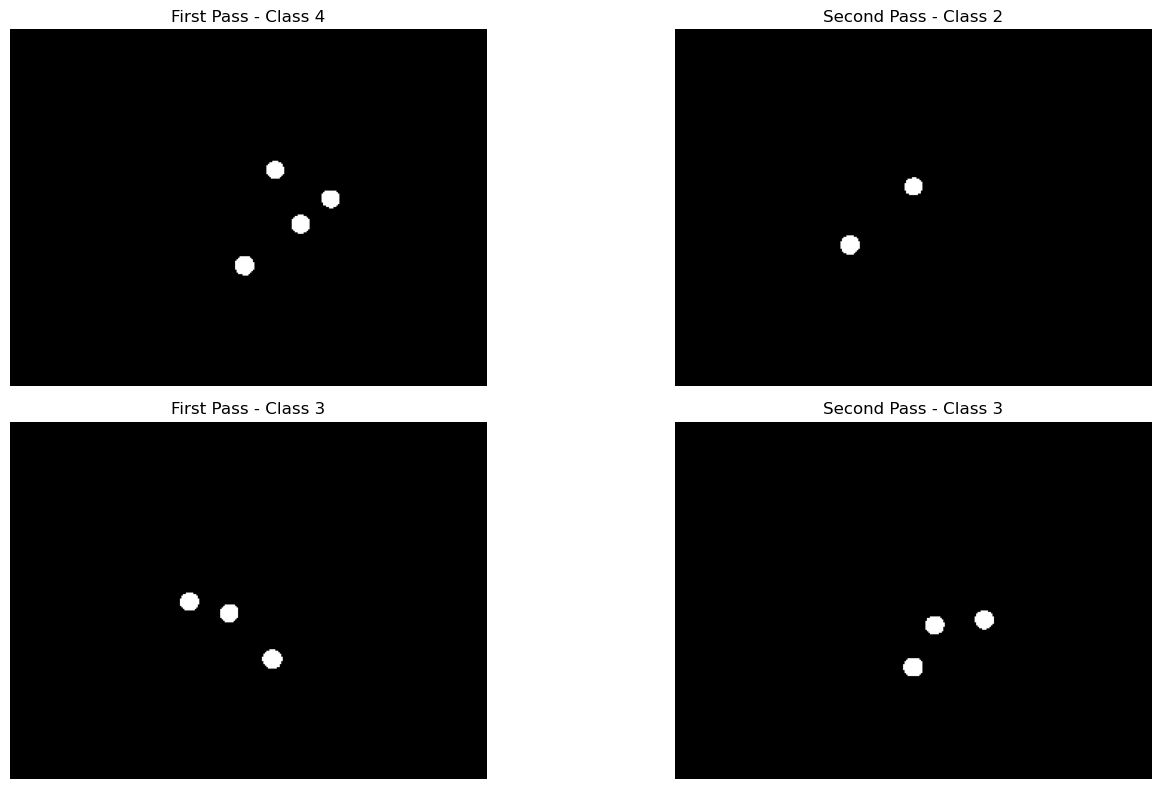

If images look different between passes, data augmentation is working!


In [11]:
# Test data augmentation
if 'train_loader' in locals():
    # Reset dataloader iterator
    train_iter = iter(train_loader)
    
    # Get the same batch multiple times to show augmentation
    try:
        plt.figure(figsize=(15, 8))
        
        # Get first batch
        batch1_x, batch1_y = next(train_iter)
        
        # Reset and get "same" batch again (should have different augmentation)
        train_iter = iter(train_loader)
        batch2_x, batch2_y = next(train_iter)
        
        # Show a comparison
        for i in range(min(2, batch1_x.shape[0])):
            # First batch version
            plt.subplot(2, 2, i*2+1)
            plt.imshow(batch1_x[i, 0].numpy(), cmap='gray')
            plt.title(f"First Pass - Class {batch1_y[i].item()+1}")
            plt.axis('off')
            
            # Second batch version (should be different due to augmentation)
            plt.subplot(2, 2, i*2+2)
            plt.imshow(batch2_x[i, 0].numpy(), cmap='gray')
            plt.title(f"Second Pass - Class {batch2_y[i].item()+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("If images look different between passes, data augmentation is working!")
        
    except StopIteration:
        print("Training loader is empty!")
    except Exception as e:
        print(f"Error testing augmentation: {e}")
else:
    print("No training loader available")

## Dataset Test Summary

If all the cells above run without errors, your dataset functionality is working correctly! The dataset is successfully:

1. Loading images from your data directories
2. Preprocessing them (resizing to 320×240 and binarizing)
3. Creating proper data loaders with train/val/test splits
4. Applying data augmentation during training

You're now ready to move on to testing the model.